# ABN

Les données historiques de la station Niamey

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [11]:
import os
from pathlib import Path

from dotenv import load_dotenv
import datetime
import xarray as xr
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import utils

from ochanticipy import (
    create_country_config,
    CodAB,
    GeoBoundingBox,
    GlofasForecast,
    GlofasReanalysis,
    GlofasReforecast,
)

pio.renderers.default = "notebook"

In [5]:
# load and get maxima
df = utils.load_combined_abn()
df = utils.shift_to_floodseason(df)
df_max = utils.get_peak(
    df, max_col="Water Level (cm)", agg_col="station", date_col="date"
)

In [13]:
# plot average by station
df_plot = df.groupby(["station", "dayofseason"]).mean().reset_index()
px.line(df_plot, x="dayofseason", y="Water Level (cm)", color="station").show()

In [9]:
# plot yearly for station
station = "Garbe Kourou"
df_plot = df[df["station"] == station]
px.line(
    df_plot, x="dayofseason", y="Water Level (cm)", color="seasonyear"
).show()

In [10]:
px.scatter(
    df.sort_values("Discharges (m3/s)"),
    y="Water Level (cm)",
    x="Discharges (m3/s)",
    color="station",
)

In [15]:
value_col = "Water Level (cm)"
year_col = "seasonyear"
agg_col = "station"
quants = np.linspace(0, 1, 101)

df_return_periods = pd.DataFrame()
df_count_yearly = pd.DataFrame()

return_years = [1.5, 2, 3, 5, 10]

for station in df_max[agg_col].unique():
    dff = df_max[df_max[agg_col] == station].set_index(year_col)[value_col]
    levels = dff.quantile(quants)
    total_years = len(dff)
    for level in levels:
        dfff = dff[dff >= level]
        years = "<br>".join(
            [str(x) for x in dfff.sort_index(ascending=False).index]
        )
        count = len(dfff)
        df_add = pd.DataFrame(
            {
                agg_col: station,
                value_col: level,
                "count": count,
                f"{year_col}s": years,
                "return": total_years / count,
            },
            index=[0],
        )
        df_count_yearly = pd.concat(
            [df_count_yearly, df_add], ignore_index=True
        )

    df_i = df_count_yearly[df_count_yearly[agg_col] == station]
    df_i = df_i.sort_values(value_col, ascending=True)
    # interpolate to find precise return periods
    interp = np.interp(return_years, df_i["return"], df_i[value_col])
    for index, return_year in enumerate(return_years):
        # but, if exact value in return periods, take lowest value
        if return_year in df_i["return"].values:
            lower_value = df_i[df_i["return"] == return_year].iloc[0][
                value_col
            ]
            interp[index] = lower_value

    df_add = pd.DataFrame()
    df_add[value_col] = interp
    df_add["return_period"] = return_years
    df_add[agg_col] = station
    df_return_periods = pd.concat(
        [df_return_periods, df_add], ignore_index=True
    )

df_return_periods = df_return_periods.set_index(["return_period", agg_col])

In [17]:
for station in df_max[agg_col].unique():
    min_year = df_max[df_max["station"] == station]["date"].min().year
    df_plot = df_count_yearly[df_count_yearly[agg_col] == station]
    x_max = 10
    y_max = df_plot[df_plot["return"] <= x_max][value_col].max()
    y_min = df_plot[value_col].min()
    fig = px.line(df_plot, x="return", y=value_col)

    for year in return_years[:-1]:
        level = df_return_periods.loc[year, station].values[0]
        fig.add_trace(
            go.Scatter(
                x=[1, x_max * 0.8],
                y=[level, level],
                mode="lines+text",
                text=[None, f" {year}-ans = {level:.0f} cm"],
                line=dict(width=1, dash="dot", color="black"),
                textposition="middle right",
            )
        )

    fig.update_xaxes(range=(1, x_max), title="Période de retour (ans)")
    fig.update_yaxes(range=(y_min, y_max), title="Niveau d'eau (cm)")

    fig.update_layout(
        template="simple_white",
        title=f"{station} période de retour (depuis {min_year})",
        showlegend=False,
        width=800,
    )
    fig.show()

## Comparison with GloFAS

In [118]:
# load GloFAS reanalysis

start_date = df_abn.index.min().date()
end_date = df_abn.index.max().date()

g_re = GlofasReanalysis(
    country_config=country_config,
    geo_bounding_box=geobb,
    start_date=start_date,
    end_date=end_date,
)
g_re.download()
g_re.process()
ds = g_re.load()
df_re = ds.to_dataframe()["Niamey"]

In [119]:
df_re

time
2005-01-01    2662.414062
2005-01-02    2625.687500
2005-01-03    2588.812500
2005-01-04    2551.812500
2005-01-05    2514.828125
                 ...     
2022-12-27    3960.984375
2022-12-28    3884.070312
2022-12-29    3808.429688
2022-12-30    3734.250000
2022-12-31    3661.539062
Name: Niamey, Length: 6574, dtype: float32

In [19]:
# GloFAS 4.0 reanalysis

g_re4 = GlofasReanalysis(
    country_config=country_config,
    geo_bounding_box=geobb,
    start_date=datetime.date(2020, 1, 1),
    end_date=datetime.date(2020, 12, 31),
)
g_re4.process()
da = g_re4.load()
df_re4 = da.to_dataframe()
df_re4

,Alcongui,Boss Bangou,Dargol A Kakassi,Dargol At Tera,Diongore Amont,Garbe-Kourou,Gorouol At Dolbel,Goulbi De Maradi A Nielloua,Kandadji,Majia At Tsernaoua,Niamey,W
time,,,,,,,,,,,,
2020-01-01,0.328125,0.031250,0.0,0.0,0.0,0.093750,0.0,0.000000,1162.750000,0.000000,1238.046875,0.0
2020-01-02,0.125000,0.031250,0.0,0.0,0.0,0.093750,0.0,0.000000,1162.984375,0.000000,1237.250000,0.0
2020-01-03,0.125000,0.031250,0.0,0.0,0.0,0.093750,0.0,0.000000,1131.921875,0.000000,1203.875000,0.0
2020-01-04,0.109375,0.015625,0.0,0.0,0.0,0.078125,0.0,0.000000,1102.437500,0.000000,1171.968750,0.0
2020-01-05,0.109375,0.015625,0.0,0.0,0.0,0.078125,0.0,0.000000,1074.453125,0.000000,1141.562500,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.218750,0.015625,0.0,0.0,0.0,0.062500,0.0,0.015625,1291.078125,0.781250,1367.640625,0.0
2020-12-28,0.218750,0.015625,0.0,0.0,0.0,0.062500,0.0,0.015625,1258.875000,0.765625,1332.468750,0.0
2020-12-29,0.203125,0.015625,0.0,0.0,0.0,0.062500,0.0,0.015625,1228.265625,0.765625,1299.078125,0.0


In [145]:
df_compare = df_abn.merge(df_re, left_index=True, right_index=True)
df_compare = df_compare.merge(
    df_re4, left_index=True, right_index=True, suffixes=["3", "4"]
)
df_compare

,Water Level (cm),Discharges (m3/s),year,Niamey3,Alcongui,Boss Bangou,Dargol A Kakassi,Dargol At Tera,Diongore Amont,Garbe-Kourou,Gorouol At Dolbel,Goulbi De Maradi A Nielloua,Kandadji,Majia At Tsernaoua,Niamey4,W
2020-01-01,554.0,1595.0,2020,3795.250000,0.328125,0.031250,0.0,0.0,0.0,0.093750,0.0,0.000000,1162.750000,0.000000,1238.046875,0.0
2020-01-02,553.5,1591.5,2020,3734.937500,0.125000,0.031250,0.0,0.0,0.0,0.093750,0.0,0.000000,1162.984375,0.000000,1237.250000,0.0
2020-01-03,553.5,1591.5,2020,3675.000000,0.125000,0.031250,0.0,0.0,0.0,0.093750,0.0,0.000000,1131.921875,0.000000,1203.875000,0.0
2020-01-04,552.5,1585.0,2020,3615.453125,0.109375,0.015625,0.0,0.0,0.0,0.078125,0.0,0.000000,1102.437500,0.000000,1171.968750,0.0
2020-01-05,553.0,1588.0,2020,3556.265625,0.109375,0.015625,0.0,0.0,0.0,0.078125,0.0,0.000000,1074.453125,0.000000,1141.562500,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,570.0,1699.0,2020,4472.960938,0.218750,0.015625,0.0,0.0,0.0,0.062500,0.0,0.015625,1291.078125,0.781250,1367.640625,0.0
2020-12-28,571.0,1706.0,2020,4390.789062,0.218750,0.015625,0.0,0.0,0.0,0.062500,0.0,0.015625,1258.875000,0.765625,1332.468750,0.0
2020-12-29,572.0,1712.0,2020,4307.664062,0.203125,0.015625,0.0,0.0,0.0,0.062500,0.0,0.015625,1228.265625,0.765625,1299.078125,0.0
2020-12-30,573.0,1719.0,2020,4224.437500,0.187500,0.015625,0.0,0.0,0.0,0.046875,0.0,0.015625,1199.109375,0.750000,1267.296875,0.0


In [174]:
# compare with GloFAS analysis

fig = go.Figure()
fig.update_layout(template="simple_white", title="Comparaison à Niamey")
fig.add_trace(
    go.Scatter(
        x=df_compare.index,
        y=df_compare["Discharges (m3/s)"],
        name="Observé (ABN)",
    )
)
fig.add_trace(
    go.Scatter(x=df_compare.index, y=df_compare["Niamey3"], name="GloFAS 3.1")
)
fig.add_trace(
    go.Scatter(x=df_compare.index, y=df_compare["Niamey4"], name="GloFAS 4.0")
)

ymax = df_compare[["Niamey3", "Niamey4", "Discharges (m3/s)"]].max().max()
fig.update_yaxes(title="Débit (m<sup>3</sup>/s)", range=[0, ymax * 1.1])


fig.show()

fig = go.Figure()
fig.update_layout(template="simple_white")
fig.add_trace(
    go.Scatter(
        x=df_compare["Water Level (cm)"],
        y=df_compare["Niamey4"],
        name="GloFAS",
        mode="markers",
    )
)
fig.show()

In [147]:
df_compare.corr()

,Water Level (cm),Discharges (m3/s),year,Niamey3,Alcongui,Boss Bangou,Dargol A Kakassi,Dargol At Tera,Diongore Amont,Garbe-Kourou,Gorouol At Dolbel,Goulbi De Maradi A Nielloua,Kandadji,Majia At Tsernaoua,Niamey4,W
Water Level (cm),1.000000,0.983697,NaN,0.415247,0.429186,0.538116,0.316302,0.291692,NaN,0.541301,0.413594,0.576765,0.433940,0.561183,0.484321,NaN
Discharges (m3/s),0.983697,1.000000,NaN,0.348511,0.507311,0.629437,0.357166,0.326460,NaN,0.633292,0.486486,0.657688,0.400725,0.644024,0.458894,NaN
year,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Niamey3,0.415247,0.348511,NaN,1.000000,-0.164398,-0.158059,-0.178701,-0.140360,NaN,-0.152776,-0.171324,0.159273,0.854524,0.103509,0.842082,NaN
Alcongui,0.429186,0.507311,NaN,-0.164398,1.000000,0.860742,0.840659,0.806145,NaN,0.860170,0.990952,0.586432,-0.009130,0.631043,0.083617,NaN
Boss Bangou,0.538116,0.629437,NaN,-0.158059,0.860742,1.000000,0.673815,0.609849,NaN,0.999249,0.837708,0.780647,0.135990,0.828396,0.222525,NaN
Dargol A Kakassi,0.316302,0.357166,NaN,-0.178701,0.840659,0.673815,1.000000,0.988349,NaN,0.667406,0.895163,0.474711,-0.068035,0.513652,0.009623,NaN
Dargol At Tera,0.291692,0.326460,NaN,-0.140360,0.806145,0.609849,0.988349,1.000000,NaN,0.605602,0.868396,0.431352,-0.046036,0.460958,0.026745,NaN
Diongore Amont,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Garbe-Kourou,0.541301,0.633292,NaN,-0.152776,0.860170,0.999249,0.667406,0.605602,NaN,1.000000,0.835956,0.782856,0.142057,0.827491,0.228654,NaN


<Axes: xlabel='time'>

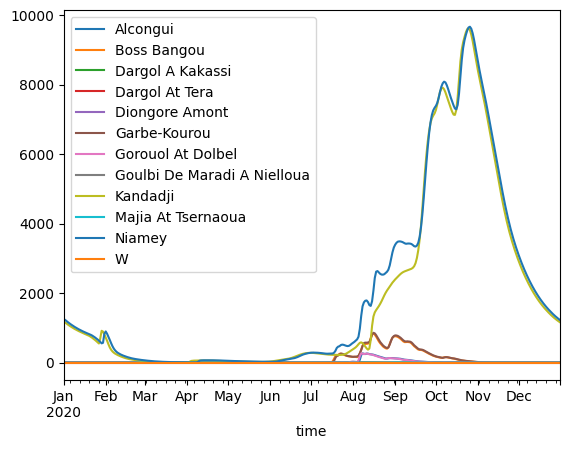

In [20]:
df_re4.plot()